# **Bird Species Classification with MobilenetV2 for Mobile Vision Application**
To develop a light-weight model with smaller size which is MobilenetV2 that could be implemented in IDE such as android studio to develop a mobile vision application that classify the bird species to particular classes with good accuracy.


# **Table of Content**


---



<font color="blue">1.   Section 1: Mount to Google Drive</font>

<font color="blue">2.  Section 2: Initialized Libraries and Helper Functions
  1. Import Libraries
  2. Setup helper functions  
    

<font color="blue">3.  Section 3: Create Datasets
 </font>

<font color="blue">4.   Section 4: Setup Modified MobileNetV2
  1. Initialized MobileNetV2 from torch.vision
  2. Modify MobileNetV2


<font color="blue">5.   Section 5: Model Comparison </font>

<font color="blue">6.   Section 6: Deep Train Orignial MobileNetV2 </font>

<font color="blue">7.   Section 7: Deep Train Modified MobileNetV2 </font>

<font color="blue">8.   Section 8: Model Evaluation on Modified MobileNetV2
  1. Precison, Recall and F1 score
  2. Confusion Matrix

<font color="blue">9.   Section 9:Compare accuracy between original    MobileNetV2 and modified MobileNetV2</font>

<font color="blue">10.   Section 10: Evaluate modified MobileNetV2 with Testing data</font>

<font color="blue">11.   Section 11: Model Deploy
  1. Convert pytorch model into TorchScript format</font>





# **Section 1: Mount to Google Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd './drive/MyDrive/Deep_Learning_Assignment/'

/content/drive/MyDrive/Deep_Learning_Assignment


# **Section 2: Initialized Libraries and Helper**

 **1. Import Libraries**

In [ ]:
import pandas as pd
import numpy as np
import copy
import torch
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
from pathlib import Path
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchsummary import summary
from PIL import Image
import os
import math
%load_ext autoreload
%autoreload 2

###For Evaluation Part
import numpy as np
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

from sklearn.metrics import plot_confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

**2. Setup helper functions**

In [ ]:
def read_image(path):
    im = Image.open(str(path))
    if im.getbands()[0] == 'L':
        im = im.convert('RGB')
    return im

In [ ]:
def show_image(img):
  img = img.numpy().transpose(1,2,0)
  img= denormalize(img)
  plt.imshow(img)

In [ ]:
def denormalize(img):
  imagenet_stats = np.array([[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]])
  return img*imagenet_stats[1] + imagenet_stats[0]

In [ ]:
def visualize(dataloader, categories):
    """Imshow for Tensor."""
    x,y = next(iter(dataloader))
    
    fig = plt.figure(figsize=(10, 10))
    for i in range(8):
      inp = x[i]
      inp = inp.numpy().transpose(1,2,0)
      inp = denormalize(inp)
      
      ax = fig.add_subplot(2, 4, i+1, xticks=[], yticks=[])
      plt.imshow(inp)
      plt.title(str(categories[y[i]]))

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
loss_iter = 1
####Training####
def train(net, num_epochs, lr, momentum, verbose=True):
    
    history = []
    labels=[]
    
    loss_iterations = int(np.ceil(len(train_loader)/loss_iter))
    
    # set the optimizer
    optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum)

    # transfer model to GPU
    if  torch.cuda.is_available():
      net = net.cuda()
    
    # set to training mode
    net.train()

    # train the network
    for e in range(num_epochs):    

        running_loss = 0.0
        running_count = 0.0

        for i, (inputs, labels) in enumerate(train_loader):

            # Clear all the gradient to 0
            optimizer.zero_grad()

            # transfer data to GPU
            if torch.cuda.is_available():
                inputs = inputs.cuda()
                labels = labels.cuda()

            # forward propagation to get h
            outs = net(inputs)

            # compute loss 
            loss = F.cross_entropy(outs, labels)

            # backpropagation to get dw
            loss.backward()

            # update w
            optimizer.step()

            # get the loss
            running_loss += loss.item()
            running_count += 1

             # display the averaged loss value 
            if i % loss_iterations == loss_iterations-1 or i == len(train_loader) - 1:                
                train_loss = running_loss / running_count
                running_loss = 0. 
                running_count = 0.
                if verbose:
                    print(f'[Epoch {e+1:2d}/{num_epochs:d} Iter {i+1:5d}/{len(train_loader)}]: train_loss = {train_loss:.4f}')   
                history.append(train_loss)
    return history

In [ ]:
labels_list=[]
predicted_list=[]
def evaluate(net,loader):
    # set to evaluation mode
    net.eval()
    # running_correct
    running_corrects = 0
    
    for inputs, targets in loader:
        
        # transfer to the GPU
        if torch.cuda.is_available():
            inputs = inputs.cuda()
            targets = targets.cuda()
        
        # perform prediction (no need to compute gradient)
        with torch.no_grad():
            outputs = net(inputs)
            _, predicted = torch.max(outputs, 1)
            running_corrects += (targets == predicted).double().sum()

        
            labels_list.append(targets)
            predicted_list.append(predicted)
            
            
    print('Accuracy = {:.2f}%'.format(100*running_corrects/len(loader.dataset)))

In [ ]:
################################### Implemented by WAN KAR HOU and teammates on 4/10/2021 ###################################
def clear_lists():
  labels_list.clear()
  predicted_list.clear()

# **Section 3:Create Datasets**

In [ ]:
labels = pd.read_csv('./CUB_19_2011/image_class_labels_19.txt', header=None, sep=" ")
labels.columns = ["id", "label"]

classes = pd.read_csv('./CUB_19_2011/class_19.txt', header=None, sep=" ")
classes.columns = ["id", "class"]

images = pd.read_csv('./CUB_19_2011/images_19.txt', header=None, sep=" ")
images.columns = ["id", "name"]

categories = [x for x in classes["class"]]

train_test = pd.read_csv('./CUB_19_2011/train_test_valid_split_19.txt', header=None, sep=" ")
train_test.columns = ["id", "is_train"]

In [ ]:
################################### Implemented by WAN KAR HOU and teammates on 4/10/2021 ###################################
class CUB(Dataset):
    def __init__(self, files_path, labels, train_test, image_name, number, 
                 transform=False):
      
        self.files_path = files_path
        self.labels = labels
        self.transform = transform
        self.train_test = train_test
        self.image_name = image_name
        
        if number==1:
          mask = self.train_test.is_train.values == 1

        elif number==2:
          mask = self.train_test.is_train.values == 2
          
        else:
          mask = self.train_test.is_train.values == 0
        
        
        self.filenames = self.image_name.iloc[mask]
        self.labels = self.labels[mask]
        self.num_files = self.labels.shape[0]
       
      
        
    def __len__(self):
        return self.num_files
    
    def __getitem__(self, index):
        y = self.labels.iloc[index,1] - 1
        
        file_name = str(self.filenames.iloc[index, 1])
        path = self.files_path/'images'/file_name
        x = read_image(path)
        x = self.transform(x)
        return x,y


In [ ]:
# Data Augmentation # transform the model
trains_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomCrop(256),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
  
test_transforms=transforms.Compose([
    transforms.Resize(256),
    transforms.RandomCrop(256),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

In [ ]:
################################### Implemented by WAN KAR HOU and teammates on 4/10/2021 ###################################
PATH = Path('./CUB_19_2011')

train_dataset = CUB(PATH, labels, train_test, images, number= 1, transform= trains_transforms)
valid_dataset = CUB(PATH, labels, train_test, images, number= 0, transform= test_transforms)
testing_dataset = CUB(PATH, labels, train_test, images, number=2, transform= test_transforms)
total_dataset = train_dataset+valid_dataset+testing_dataset
print(len(train_dataset))
print(len(valid_dataset))
print(len(testing_dataset))
print((len(total_dataset)))


569
275
274
1118


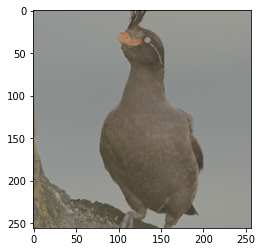

In [ ]:
# If you get an error, restart the runtime

show_image(train_dataset[0][0])

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_dataset, batch_size=32, num_workers=2)
################################### Implemented by WAN KAR HOU and teammates on 4/10/2021 ###################################
testing_loader = DataLoader(testing_dataset, batch_size=32, num_workers=2)

In [ ]:
dataiter = iter(train_loader)
imgs, labels = dataiter.next()
print('Shape of imgs:', imgs.shape)
print('Shape of labels:', labels.shape)
print(len(train_loader))

Shape of imgs: torch.Size([32, 3, 256, 256])
Shape of labels: torch.Size([32])
18


Shape of imgs: torch.Size([32, 3, 256, 256])
Shape of grid_img: torch.Size([3, 1034, 2066])


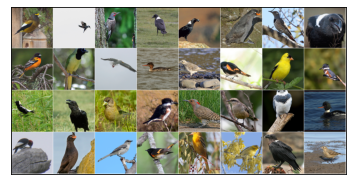

labels: tensor([ 54,  78,  35, 107, 107,   4,  35, 107,  94,  74,  58,  89, 103, 108,
         46,  78,  12, 107,  54,  78,  35,  90,  78,  89, 190,   4,  90, 108,
         94, 162, 107, 103])


In [ ]:
# stack the batch image horizontally
grid_img = torchvision.utils.make_grid(imgs, pad_value=1)
print('Shape of imgs:', imgs.shape) 
print('Shape of grid_img:', grid_img.shape) 
# undo normalization
grid_img = grid_img*0.5 + 0.5
# Convert back to image: (3, 32, 138) -> (32, 138, 3)
grid_img = np.transpose(grid_img,(1,2,0))
# display image
plt.imshow(grid_img)
plt.xticks([])
plt.yticks([])
plt.show()
print('labels:', labels[:64])


# **Section 4: Setup Modified MobileNetV2**



 **1.Initialized MobileNetV2 from torch.vison**

Initalized MobileNetV2 from torchvison.models .

              

In [ ]:
mobile_net_ori=models.mobilenet_v2(pretrained=False)



View the structure of MobileNetV2 

In [ ]:
print(mobile_net_ori)

MobileNetV2(
  (features): Sequential(
    (0): ConvBNActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momen

In [ ]:
for name, _ in mobile_net_ori.named_children():
  print(name)

features
classifier


**2. Modify MobileNetV2**

Perform Modification on MobileNetV2 by Adding Global Pooling Layer and change the classifier layer with the purpose of prevent overfiting and  reducing model paramater thus make the size of model smaller , so that it can be suitable to be implemented in mobile application

In [ ]:
################################### Implemented by WAN KAR HOU and teammates on 4/10/2021 ###################################
mobile_net_modified=models.mobilenet_v2(pretrained=False)

module=nn.Sequential(
          nn.AdaptiveAvgPool2d((1,1)).cuda(),
            )
mobile_net_modified.features.add_module("AVG",module)

mobile_net_modified.classifier=nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(1280,800),
  )
mobile_net_modified.fc =nn.Sequential(
                          nn.Linear(800,19),
                        )


View the structure of lastest modified model

In [ ]:
print(mobile_net_modified)

MobileNetV2(
  (features): Sequential(
    (0): ConvBNActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momen

In [ ]:
for name, _ in mobile_net_modified.named_children():
  print(name)

features
classifier
fc


# **Section 5: Models Sizes Comparison**

Compare the size of model of both original MobileNetV2 and modified MobileNetV2

Modified MobileNetV2 had lower model parameters and smaller size compared to original MobileNetV2, with around 200,000 params lesser and 1MB smaller

**Original MobileNetV2**

In [ ]:
summary(mobile_net_ori, (3, 256, 256), device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             864
       BatchNorm2d-2         [-1, 32, 128, 128]              64
             ReLU6-3         [-1, 32, 128, 128]               0
            Conv2d-4         [-1, 32, 128, 128]             288
       BatchNorm2d-5         [-1, 32, 128, 128]              64
             ReLU6-6         [-1, 32, 128, 128]               0
            Conv2d-7         [-1, 16, 128, 128]             512
       BatchNorm2d-8         [-1, 16, 128, 128]              32
  InvertedResidual-9         [-1, 16, 128, 128]               0
           Conv2d-10         [-1, 96, 128, 128]           1,536
      BatchNorm2d-11         [-1, 96, 128, 128]             192
            ReLU6-12         [-1, 96, 128, 128]               0
           Conv2d-13           [-1, 96, 64, 64]             864
      BatchNorm2d-14           [-1, 96,

**Modified MobileNetV2**

In [ ]:
summary(mobile_net_modified, (3, 256, 256), device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             864
       BatchNorm2d-2         [-1, 32, 128, 128]              64
             ReLU6-3         [-1, 32, 128, 128]               0
            Conv2d-4         [-1, 32, 128, 128]             288
       BatchNorm2d-5         [-1, 32, 128, 128]              64
             ReLU6-6         [-1, 32, 128, 128]               0
            Conv2d-7         [-1, 16, 128, 128]             512
       BatchNorm2d-8         [-1, 16, 128, 128]              32
  InvertedResidual-9         [-1, 16, 128, 128]               0
           Conv2d-10         [-1, 96, 128, 128]           1,536
      BatchNorm2d-11         [-1, 96, 128, 128]             192
            ReLU6-12         [-1, 96, 128, 128]               0
           Conv2d-13           [-1, 96, 64, 64]             864
      BatchNorm2d-14           [-1, 96,

# **Section 6: Deep Train Orignial Mobile NetV2**

In [ ]:
model_deep_train_ori=train(mobile_net_ori, num_epochs=300, lr=0.055, momentum=0.9)

[Epoch  1/300 Iter    18/18]: train_loss = 4.6635
[Epoch  2/300 Iter    18/18]: train_loss = 3.5785
[Epoch  3/300 Iter    18/18]: train_loss = 3.0400
[Epoch  4/300 Iter    18/18]: train_loss = 2.9653
[Epoch  5/300 Iter    18/18]: train_loss = 2.7886
[Epoch  6/300 Iter    18/18]: train_loss = 2.5106
[Epoch  7/300 Iter    18/18]: train_loss = 2.3321
[Epoch  8/300 Iter    18/18]: train_loss = 2.2688
[Epoch  9/300 Iter    18/18]: train_loss = 2.0973
[Epoch 10/300 Iter    18/18]: train_loss = 2.0664
[Epoch 11/300 Iter    18/18]: train_loss = 2.0769
[Epoch 12/300 Iter    18/18]: train_loss = 1.8545
[Epoch 13/300 Iter    18/18]: train_loss = 1.8852
[Epoch 14/300 Iter    18/18]: train_loss = 1.7102
[Epoch 15/300 Iter    18/18]: train_loss = 1.6316
[Epoch 16/300 Iter    18/18]: train_loss = 1.5797
[Epoch 17/300 Iter    18/18]: train_loss = 1.5681
[Epoch 18/300 Iter    18/18]: train_loss = 1.3783
[Epoch 19/300 Iter    18/18]: train_loss = 1.2618
[Epoch 20/300 Iter    18/18]: train_loss = 1.3564


In [ ]:
print("Training ")
evaluate(mobile_net_ori,train_loader)
clear_lists()

Training 
Accuracy = 100.00%


In [ ]:
print("Validation :")
evaluate(mobile_net_ori,valid_loader)
clear_lists()

Validation :
Accuracy = 59.27%


# **Section 7: Deep Train Modified MobileNetv2**

In [ ]:
model_deep_train=train(mobile_net_modified, num_epochs=300, lr=0.055, momentum=0.9)

[Epoch  1/300 Iter    18/18]: train_loss = 4.2983
[Epoch  2/300 Iter    18/18]: train_loss = 4.3494
[Epoch  3/300 Iter    18/18]: train_loss = 4.2889
[Epoch  4/300 Iter    18/18]: train_loss = 3.2804
[Epoch  5/300 Iter    18/18]: train_loss = 3.1142
[Epoch  6/300 Iter    18/18]: train_loss = 2.7145
[Epoch  7/300 Iter    18/18]: train_loss = 2.4383
[Epoch  8/300 Iter    18/18]: train_loss = 2.4290
[Epoch  9/300 Iter    18/18]: train_loss = 2.3951
[Epoch 10/300 Iter    18/18]: train_loss = 2.1878
[Epoch 11/300 Iter    18/18]: train_loss = 2.1586
[Epoch 12/300 Iter    18/18]: train_loss = 2.1085
[Epoch 13/300 Iter    18/18]: train_loss = 2.0009
[Epoch 14/300 Iter    18/18]: train_loss = 1.9674
[Epoch 15/300 Iter    18/18]: train_loss = 1.8529
[Epoch 16/300 Iter    18/18]: train_loss = 1.7971
[Epoch 17/300 Iter    18/18]: train_loss = 1.7500
[Epoch 18/300 Iter    18/18]: train_loss = 1.6503
[Epoch 19/300 Iter    18/18]: train_loss = 1.5184
[Epoch 20/300 Iter    18/18]: train_loss = 1.4095


In [ ]:
print("Training ")
evaluate(mobile_net_modified,train_loader)
clear_lists()

Training 
Accuracy = 99.82%


In [ ]:
print("Validation :")
evaluate(mobile_net_modified,valid_loader)

Validation :
Accuracy = 54.55%


# **Section 8: Model Evaluation of Modified MobileNetV2**

**1. Precision, Recall , F1 Score**

Form array list for labels during evaluation of valid_loader


In [ ]:
################################### Implemented by WAN KAR HOU and teammates on 4/10/2021 ###################################

###Convert tensor to numpy####
labels_com_list=[]
for i in range(len(labels_list)):
  labels_com_list.append(labels_list[i].detach().cpu().numpy())

###Combine array together
labels_arr=[]
for i in range(len(labels_com_list)):
    labels_arr=np.concatenate((labels_com_list[i],labels_arr))

print(np.array(labels_arr))
  

[190. 190. 190. 190. 193. 193. 193. 193. 193. 193. 193. 193. 193. 193.
 193. 193. 193. 193. 193. 162. 162. 162. 162. 162. 162. 165. 165. 165.
 165. 165. 165. 165. 165. 165. 165. 165. 165. 165. 165. 165. 190. 190.
 190. 190. 190. 190. 190. 190. 190. 190. 190. 107. 107. 107. 107. 107.
 107. 107. 107. 108. 108. 108. 108. 108. 108. 108. 108. 108. 108. 108.
 108. 108. 108. 108. 162. 162. 162. 162. 162. 162. 162. 162. 162.  94.
  94.  94.  94.  94.  94.  94.  94.  94.  94. 103. 103. 103. 103. 103.
 103. 103. 103. 103. 103. 103. 103. 103. 103. 103. 107. 107. 107. 107.
 107. 107. 107.  89.  89.  89.  89.  89.  89.  89.  89.  89.  89.  89.
  89.  90.  90.  90.  90.  90.  90.  90.  90.  90.  90.  90.  90.  90.
  90.  90.  94.  94.  94.  94.  94.  66.  74.  74.  74.  74.  74.  74.
  74.  74.  74.  74.  74.  74.  74.  78.  78.  78.  78.  78.  78.  78.
  78.  78.  78.  78.  78.  78.  78.  78.  89.  89.  89.  54.  54.  54.
  58.  58.  58.  58.  58.  58.  58.  58.  58.  58.  58.  58.  58.  58.
  58. 

Form array list for predicted output during evaluation of valid_loader

In [ ]:
################################### Implemented by WAN KAR HOU and teammates on 4/10/2021 ###################################
pred_list=[]
###Convert tensor to numpy
for i in range(len(predicted_list)):
  pred_list.append(predicted_list[i].detach().cpu().numpy())
###Combine array together
predicted_arr=[]
for i in range(len(pred_list)):
    predicted_arr=np.concatenate((pred_list[i],predicted_arr))
print(predicted_arr)

[190.  66. 193. 190. 103. 103. 193. 103.  90.  66.  12. 193.  78.  78.
  12. 193.  90. 103.  90. 162. 162. 108. 162. 162. 162.  35.  90. 193.
  90. 165. 165. 165. 165. 165. 165. 165. 165. 165. 165.  46. 190. 190.
 190. 190. 190. 190. 190. 190.  66. 190. 190. 103.  74. 107. 107. 190.
 107. 103.  54. 108. 108. 108. 108.  78. 108.  89.  74. 108. 108. 108.
 108. 162. 108.  89. 162.  46. 162. 162. 165. 162. 162.  66.  90.  94.
  94.  94.  94.  58.  94.  94.  94.  94.  94.  66.   4.  66. 103.  78.
  89.  94. 103. 103. 103. 103. 103.  90. 103.  90. 107. 107. 103. 107.
 190.  54. 107.  89.  89. 103.  89.  89. 103.  89.  89.  74.  89.  89.
  89.  74. 103. 193.  90.  90.  89.  90. 103. 107.  35. 103. 108. 193.
  78.  74.  94.  94.  54.  66. 108. 165.  74.  74.  74.  74.  74.  74.
  74.  74.  74.  74.  78.  74.  74.  74.  78. 108.  90.  89.  78.  78.
 190.  78.  78.  94. 107.  78. 107.  78.  89.  89.  89.  54.  35.  35.
  58.  58.  90.  89. 103. 107. 103.  58. 103. 103.  58.  74. 103.  66.
  58. 

Classification Report

In [ ]:
################################### Implemented by WAN KAR HOU and teammates on 4/10/2021 ###################################
print(classification_report(labels_arr, predicted_arr))

              precision    recall  f1-score   support

         4.0       0.60      0.86      0.71         7
        12.0       0.87      0.87      0.87        15
        35.0       0.12      0.07      0.09        15
        46.0       0.83      0.67      0.74        15
        54.0       0.56      0.33      0.42        15
        58.0       0.71      0.33      0.45        15
        66.0       0.35      0.40      0.38        15
        74.0       0.57      0.92      0.71        13
        78.0       0.47      0.47      0.47        15
        89.0       0.63      0.80      0.71        15
        90.0       0.16      0.20      0.18        15
        94.0       0.79      0.73      0.76        15
       103.0       0.25      0.47      0.33        15
       107.0       0.58      0.47      0.52        15
       108.0       0.67      0.67      0.67        15
       162.0       0.77      0.67      0.71        15
       165.0       0.67      0.67      0.67        15
       190.0       0.71    

In [ ]:
################################### Implemented by WAN KAR HOU and teammates on 4/10/2021 ###################################
print('Precision={:.4f}'.format(precision_score(labels_arr,predicted_arr, pos_label='positive',average='micro')))
print('Recall={:.4f} '.format(recall_score (labels_arr,predicted_arr,pos_label='positive',average='micro')))
print('F1 Score ={:.4f}'.format(f1_score(labels_arr,predicted_arr,pos_label='positive',average='micro')))

Precision=0.5455
Recall=0.5455 
F1 Score =0.5455


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1321: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  % (pos_label, average), UserWarning)


**2. Confusion matrix**

Form a list for class of dataset

In [ ]:
 ################################### Implemented by WAN KAR HOU and teammates on 4/10/2021 ###################################
 cm_labels_list=classes["class"].tolist()
 print(cm_labels_list)

['005.Crested_Auklet', '013.Bobolink', '036.Northern_Flicker', '047.American_Goldfinch', '055.Evening_Grosbeak', '059.California_Gull', '067.Anna_Hummingbird', '075.Green_Jay', '079.Belted_Kingfisher', '090.Red_breasted_Merganser', '091.Mockingbird', '095.Baltimore_Oriole', '104.American_Pipit', '108.White_necked_Raven', '109.American_Redstart', '163.Cape_May_Warbler', '166.Golden_winged_Warbler', '191.Red_headed_Woodpecker', '194.Cactus_Wren']


Show diagram of confusion matrix

[[ 6  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0]
 [ 0 13  1  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 2  0  1  0  0  1  2  0  1  0  2  0  3  0  0  0  0  1  2]
 [ 0  0  1 10  0  0  0  1  0  0  0  0  0  0  0  2  1  0  0]
 [ 0  0  3  0  5  0  0  1  0  1  1  0  1  0  1  0  2  0  0]
 [ 0  0  0  0  0  5  1  1  0  1  1  0  5  1  0  0  0  0  0]
 [ 1  0  0  0  1  0  6  0  1  0  2  1  0  1  0  0  1  1  0]
 [ 0  0  0  0  0  0  0 12  1  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  1  7  1  1  1  0  2  1  0  0  1  0]
 [ 0  0  0  0  0  0  0  1  0 12  0  0  2  0  0  0  0  0  0]
 [ 0  0  1  0  0  0  0  2  1  1  3  0  3  1  1  0  0  0  2]
 [ 0  0  0  0  1  1  1  0  0  0  0 11  0  0  1  0  0  0  0]
 [ 1  0  0  0  0  0  2  0  1  1  2  1  7  0  0  0  0  0  0]
 [ 0  0  0  0  2  0  0  1  0  0  0  0  3  7  0  0  0  2  0]
 [ 0  0  0  0  0  0  0  1  1  2  0  0  0  0 10  1  0  0  0]
 [ 0  0  0  1  0  0  1  0  0  0  1  0  0  0  1 10  1  0  0]
 [ 0  0  1  1  0  0  0  0  0  0  2  0  0

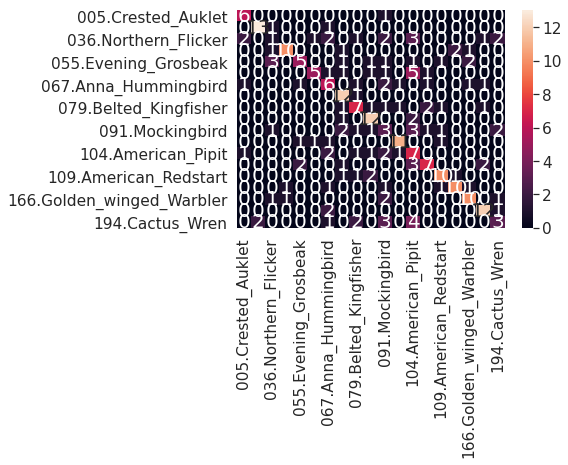

In [ ]:
cm = confusion_matrix (labels_arr, predicted_arr)
print(cm)
df_cm = pd.DataFrame(cm,cm_labels_list, cm_labels_list)
# plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size":"20" }) # font size

plt.show()

# **Section 9: Compare accuracy between original    MobileNetV2 and modified MobileNetV2**

Original MobileNetV2 achieves around 59.27% for validation accuracy while Modified MobileNetV2 achieves 54.55% for validation accuracy

# **Section 10:Evaluate modified MobileNetV2with Testing Dataset**

In [ ]:
print("Testing")
evaluate(mobile_net_modified,testing_loader)
clear_lists()

Testing
Accuracy = 47.08%


# **Section 11: Deploy Model**

**1. Convert Pytorch model into TorchScript format**

In order for pytorch model to be implement into Android app , it had to be converted to torchscript format


In [ ]:
################################### Implemented by WAN KAR HOU and teammates on 4/10/2021 ###################################
mobile_net_convert=models.mobilenet_v2(pretrained=False)

module=nn.Sequential(
          nn.AdaptiveAvgPool2d((1,1)).cuda(),
            )
mobile_net_convert.features.add_module("AVG",module)

mobile_net_convert.classifier=nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(1280,800),
  )
mobile_net_convert.fc =nn.Sequential(
                          nn.Linear(800,19),
                        )


In [ ]:
input_tensor = torch.rand(1,3,256,256)
mobile_net_convert.eval()
script_model = torch.jit.trace(mobile_net_convert,input_tensor)
script_model.save("BirdSpeciesClassifierWithMobileNetV2.pt")